# Figure 1

- Goal of this notebook is to make Figure 1 for our manuscript
- We need one overal term to describe the global trend of extreme heat events over time

#### Dependencies

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import seaborn as sns

#### Load and arrange data

In [2]:
# file paths
DATA_IN = "/home/cascade/projects/data_out_urbanheat/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FN_stats = 'All_data20200102.csv'
df_stats = pd.read_csv(DATA_IN+FN_stats)
FIG_OUT = '/home/cascade/projects/figures/'

FN_pop = 'GHS-UCDB-Interp.csv'
df_pop = pd.read_csv(DATA_IN+FN_pop)

## Let's explore the data

In [3]:
df_stats.head()

,Unnamed: 0,Unnamed: 0.1,CTR_MN_NM,Event_ID,ID_HDC_G0,avg_intensity,avg_temp,duration,event_dates,intensity,tmax,tot_intensity,total_days,year,region,sub-region,intermediate-region,GCPNT_LAT,GCPNT_LON
0,0,0,Germany,1,2784,3.859750,44.459750,1,['1983.07.27'],[3.85975],[44.45975],3.859750,1,1983,Europe,Western Europe,Western Europe,48.138002,11.563435
1,1,763004,Germany,763005,2784,0.058337,40.658337,1,['2013.08.06'],[0.058337],[40.658337],0.058337,1,2013,Europe,Western Europe,Western Europe,48.138002,11.563435
2,2,3,Germany,4,2833,6.893180,47.493180,1,['1983.07.27'],[6.89318],[47.49318],6.893180,1,1983,Europe,Western Europe,Western Europe,47.849642,12.102591
3,3,22702,Germany,22703,2833,1.187350,41.787350,1,['1984.07.11'],[1.18735],[41.78735],1.187350,1,1984,Europe,Western Europe,Western Europe,47.849642,12.102591
4,4,349978,Germany,349979,2833,0.793425,41.393425,1,['1998.08.11'],[0.793425],[41.393425],0.793425,1,1998,Europe,Western Europe,Western Europe,47.849642,12.102591


In [4]:
df_pop.head()

,Unnamed: 0,P1975,P1976,P1977,P1978,P1979,P1980,P1981,P1982,P1983,...,P2008,P2009,P2010,P2011,P2012,P2013,P2014,P2015,P2016,ID_HDC_G0
0,0,76680.403870,76724.995508,76769.587146,76814.178784,76858.770422,76903.362061,76947.953699,76992.545337,77037.136975,...,71934.628198,71518.810376,71102.992554,70687.174731,70271.356909,69855.539087,69439.721265,69023.903442,69023.903442,5782
1,1,432518.760010,430308.818037,428098.876064,425888.934091,423678.992118,421469.050145,419259.108173,417049.166200,414839.224227,...,313888.948027,309323.046789,304757.145551,300191.244313,295625.343076,291059.441838,286493.540600,281927.639362,281927.639362,3316
2,2,83301.193208,82988.143283,82675.093359,82362.043434,82048.993509,81735.943584,81422.893660,81109.843735,80796.793810,...,85470.066025,86991.949188,88513.832352,90035.715515,91557.598679,93079.481842,94601.365005,96123.248169,96123.248169,5645
3,3,59961.838394,60449.793404,60937.748414,61425.703424,61913.658434,62401.613444,62889.568454,63377.523464,63865.478474,...,78991.555206,79636.309448,80281.063690,80925.817932,81570.572174,82215.326416,82860.080658,83504.834900,83504.834900,3185
4,4,216241.069946,215363.900885,214486.731824,213609.562762,212732.393701,211855.224640,210978.055579,210100.886517,209223.717456,...,167489.228621,165714.085614,163938.942607,162163.799599,160388.656592,158613.513584,156838.370577,155063.227570,155063.227570,3539


## Make Population Long Format

In [5]:
# Make Population Long Format

pop_long = pd.wide_to_long(df_pop, stubnames = 'P', i = 'ID_HDC_G0', j = 'year')
pop_long.reset_index(level=0, inplace=True)
pop_long.reset_index(level=0, inplace=True)
pop_long = pop_long.drop('Unnamed: 0', axis = 1)

In [6]:
pop_long

,year,ID_HDC_G0,P
0,1975,5782,76680.403870
1,1975,3316,432518.760010
2,1975,5645,83301.193208
3,1975,3185,59961.838394
4,1975,3539,216241.069946
...,...,...,...
551665,2016,13046,70726.404129
551666,2016,1116,110865.699524
551667,2016,1114,108875.221680
551668,2016,1161,55765.187012


## Calc People Days

In [7]:
# Get Total Days 

data = df_stats.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates

pdays = pd.DataFrame()
pdays['ID_HDC_G0'] = data['ID_HDC_G0']
pdays['year'] = data['year']
pdays['total_days'] = data['total_days']
pdays['CTR_MN_NM'] = data['CTR_MN_NM']
pdays['sub-region'] = data['sub-region']

In [8]:
# Try to merge with Pdays
print(len(pdays))
pdays_merge = pdays.merge(pop_long, on=['ID_HDC_G0', 'year'], how = 'left')
print(len(pdays_merge))

153517
153517


In [9]:
pdays_merge.head()

,ID_HDC_G0,year,total_days,CTR_MN_NM,sub-region,P
0,2784,1983,1,Germany,Western Europe,9.976361e+05
1,2784,2013,1,Germany,Western Europe,1.538112e+06
2,2833,1983,1,Germany,Western Europe,6.014093e+04
3,2833,1984,1,Germany,Western Europe,6.033127e+04
4,2833,1998,1,Germany,Western Europe,6.411484e+04


#### Issues

- when using the first ten years there are nans because not all cities had a heat wave in the first ten years
- for now going to set all NANs to zero, but another solution is to just drop them
- another idea is just to use 1983 population as a baseline ... e.g. holding population constant what is the increase in people days by heat 

In [10]:
# Now get avg number of days per year for each city and calc people days

# 34-year avg days per year
# avgdays = df_stats.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
# avgdays = avgdays.groupby('ID_HDC_G0')['total_days'].mean()

# first ten-year avg days per year
avgdays = df_stats.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
avgdays = avgdays[(avgdays['year'] >= 1983) & (avgdays['year'] <= 1992)]
avgdays = avgdays.groupby('ID_HDC_G0')['total_days'].mean()

# Try to merge with Pdays
print(len(pdays))
pdays_merge = pdays_merge.merge(avgdays, on=['ID_HDC_G0'], how = 'left')
print(len(pdays_merge))
pdays_merge = pdays_merge.rename(columns={'total_days_x': 'total_days', 'total_days_y': 'total_days_avg'})

153517
153517


In [11]:
# Check for Nans
pdays_merge[pd.isnull(pdays_merge).any(axis=1)]

,ID_HDC_G0,year,total_days,CTR_MN_NM,sub-region,P,total_days_avg
41,1998,2003,1,France,Western Europe,330049.320209,NaN
42,1897,2003,1,France,Western Europe,550989.959540,NaN
43,2017,2010,1,France,Western Europe,627370.420171,NaN
44,1927,2015,1,France,Western Europe,112672.350098,NaN
274,5804,2012,1,Kazakhstan,Central Asia,136567.468567,NaN
...,...,...,...,...,...,...,...
153512,358,2013,1,Belize,Latin America and the Caribbean,68889.835064,NaN
153513,4297,2015,1,Uganda,Sub-Saharan Africa,73807.964355,NaN
153514,3364,2016,2,Republic of Congo,Sub-Saharan Africa,79344.519775,NaN
153515,3347,2016,2,Republic of Congo,Sub-Saharan Africa,110878.187500,NaN


In [12]:
# Fill nans
pdays_merge = pdays_merge.fillna(value = 0)

In [13]:
pdays_merge.dtypes

ID_HDC_G0           int64
year                int64
total_days          int64
CTR_MN_NM          object
sub-region         object
P                 float64
total_days_avg    float64
dtype: object

In [14]:
pdays_merge['people_days'] = pdays_merge['total_days'] * pdays_merge['P'] / 10**9
pdays_merge['people_days_avg'] = pdays_merge['total_days_avg'] * pdays_merge['P'] / 10**9


In [15]:
pdays_merge.head()

,ID_HDC_G0,year,total_days,CTR_MN_NM,sub-region,P,total_days_avg,people_days,people_days_avg
0,2784,1983,1,Germany,Western Europe,9.976361e+05,1.0,0.000998,0.000998
1,2784,2013,1,Germany,Western Europe,1.538112e+06,1.0,0.001538,0.001538
2,2833,1983,1,Germany,Western Europe,6.014093e+04,1.0,0.000060,0.000060
3,2833,1984,1,Germany,Western Europe,6.033127e+04,1.0,0.000060,0.000060
4,2833,1998,1,Germany,Western Europe,6.411484e+04,1.0,0.000064,0.000064


## How has exposure changed overtime?
- First we do it with all data
- Second we do it holding 1983 population constant
- Third we do it with avg days split over 15 year periods (both with real population change and 1983 pop)
- Next we do it with avg days per year in ten year intervals (both with real population change and 1983 pop)

**OR WE DO DELTA POPULATION** !

In [16]:
# styles
kwargs = {'linewidth':0.7, 'marker': 'o'} #linestyle: '--'

# Make Years List
years = np.unique(df_stats['year'])
years

array([1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016])

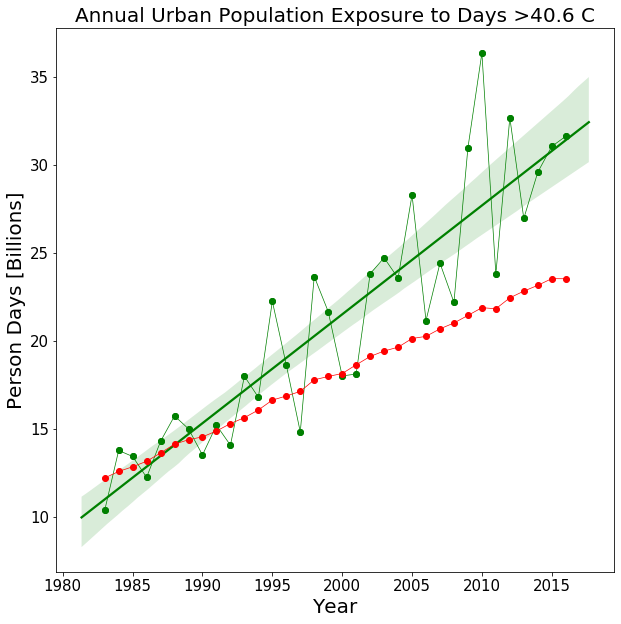

In [17]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

# Total Days
data = pdays_merge.groupby(['year'])['people_days'].sum()
sns.regplot(years, data, color = 'green', ax = ax1)
ax1.plot(data, **kwargs, color = 'green')

# Total Days first ten avg 
data = pdays_merge.groupby(['year'])['people_days_avg'].sum()
#sns.regplot(years, data, color = 'red', ax = ax1)
ax1.plot(data, **kwargs, color = 'red')

ax1.set_title('Annual Urban Population Exposure to Days >40.6 C', fontsize = 20)
ax1.set_ylabel('Person Days [Billions]', fontsize = 20)
ax1.set_xlabel('Year', fontsize = 20)
ax1.tick_params(labelsize = 15)

#plt.savefig(FIG_OUT+'AGU_Global_PersonDays.png')

## What happens when we hold population constant?

In [18]:
# Get Total Days 

data = df_stats.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates

pdays = pd.DataFrame()
pdays['ID_HDC_G0'] = data['ID_HDC_G0']
pdays['year'] = data['year']
pdays['total_days'] = data['total_days']
pdays['CTR_MN_NM'] = data['CTR_MN_NM']
pdays['sub-region'] = data['sub-region']

p83 = pd.DataFrame()
p83['ID_HDC_G0'] = df_pop['ID_HDC_G0']
p83['P1983'] = df_pop['P1983']

pdays = pdays.merge(p83, on = 'ID_HDC_G0', how = 'left')

pdays_merge = pd.DataFrame()
pdays_merge = pdays.merge(pop_long, on=['ID_HDC_G0', 'year'], how = 'left')
pdays_merge.head()

,ID_HDC_G0,year,total_days,CTR_MN_NM,sub-region,P1983,P
0,2784,1983,1,Germany,Western Europe,997636.118717,9.976361e+05
1,2784,2013,1,Germany,Western Europe,997636.118717,1.538112e+06
2,2833,1983,1,Germany,Western Europe,60140.932532,6.014093e+04
3,2833,1984,1,Germany,Western Europe,60140.932532,6.033127e+04
4,2833,1998,1,Germany,Western Europe,60140.932532,6.411484e+04


In [19]:
pdays_merge['people_days'] = pdays_merge['total_days'] * pdays_merge['P'] / 10**9
pdays_merge['people_days_83'] = pdays_merge['total_days'] * pdays_merge['P1983'] / 10**9


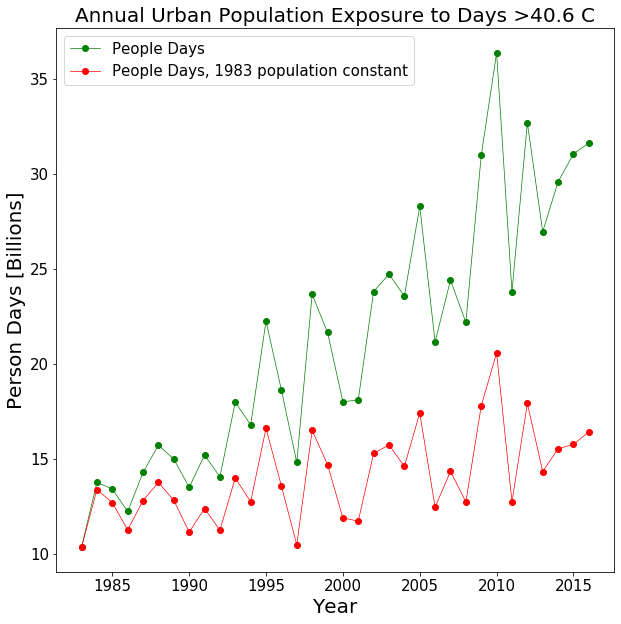

In [20]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

# Total Days
data = pdays_merge.groupby(['year'])['people_days'].sum()
#sns.regplot(years, data, color = 'green', ax = ax1, label='_nolegend_')
ax1.plot(data, **kwargs, color = 'green')

# Total Days first ten avg 
data = pdays_merge.groupby(['year'])['people_days_83'].sum()
#sns.regplot(years, data, color = 'red', ax = ax1)
ax1.plot(data, **kwargs, color = 'red')

# Title
ax1.set_title('Annual Urban Population Exposure to Days >40.6 C', fontsize = 20)
ax1.set_ylabel('Person Days [Billions]', fontsize = 20)
ax1.set_xlabel('Year', fontsize = 20)
ax1.tick_params(labelsize = 15)

# legend
leg_labels = ['People Days', 'People Days, 1983 population constant']
plt.legend(leg_labels, fontsize = 15)

#plt.savefig(FIG_OUT+'AGU_Global_PersonDays.png')

# What happens when we only look at incease in people, not days?

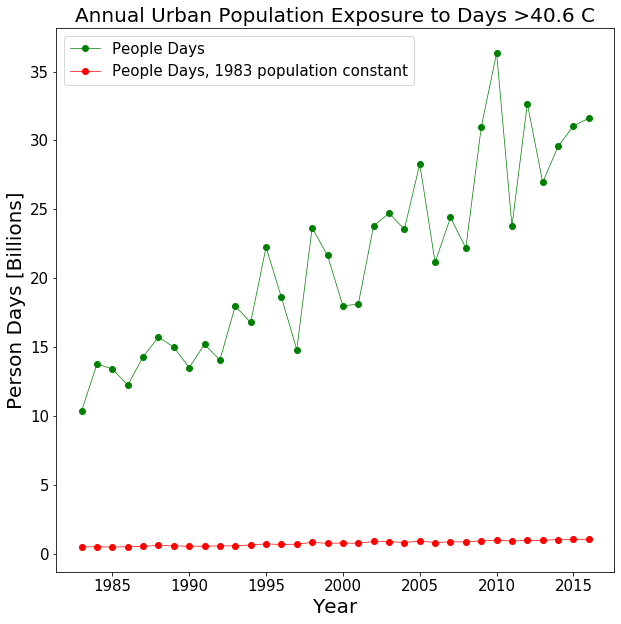

In [21]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

# Total Days
data = pdays_merge.groupby(['year'])['people_days'].sum()
#sns.regplot(years, data, color = 'green', ax = ax1, label='_nolegend_')
ax1.plot(data, **kwargs, color = 'green')

# Total Days first ten avg 
data = pdays_merge.groupby('year')['P'].sum() / 10**9
#sns.regplot(years, data, color = 'red', ax = ax1)
ax1.plot(data, **kwargs, color = 'red')

# Title
ax1.set_title('Annual Urban Population Exposure to Days >40.6 C', fontsize = 20)
ax1.set_ylabel('Person Days [Billions]', fontsize = 20)
ax1.set_xlabel('Year', fontsize = 20)
ax1.tick_params(labelsize = 15)

# legend
leg_labels = ['People Days', 'People Days, 1983 population constant']
plt.legend(leg_labels, fontsize = 15)

#plt.savefig(FIG_OUT+'AGU_Global_PersonDays.png')

In [22]:
pdays_merge.groupby('year')['P'].sum()

year
1983    5.124315e+08
1984    5.264431e+08
1985    5.023436e+08
1986    5.266425e+08
1987    5.525738e+08
1988    6.262942e+08
1989    5.870233e+08
1990    5.682694e+08
1991    5.669395e+08
1992    5.885925e+08
1993    5.908864e+08
1994    6.613592e+08
1995    7.340196e+08
1996    6.947248e+08
1997    7.141938e+08
1998    8.399672e+08
1999    7.793975e+08
2000    8.004206e+08
2001    7.765410e+08
2002    9.124983e+08
2003    9.057882e+08
2004    8.302197e+08
2005    9.452088e+08
2006    8.321399e+08
2007    8.852705e+08
2008    8.714883e+08
2009    9.627411e+08
2010    1.001877e+09
2011    9.387558e+08
2012    9.923825e+08
2013    9.923002e+08
2014    1.052562e+09
2015    1.065342e+09
2016    1.069360e+09
Name: P, dtype: float64

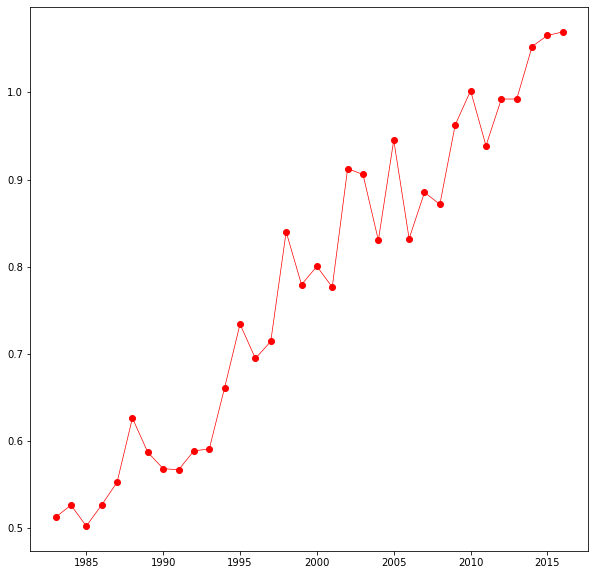

In [23]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)


# Total Days first ten avg 
data = pdays_merge.groupby('year')['P'].sum() / 10**9
#sns.regplot(years, data, color = 'red', ax = ax1)
ax1.plot(data, **kwargs, color = 'red')

# What happens when we look at per capita change?

In [37]:
# How many people in a given year were exposed?

total_people = pdays_merge.groupby('year')['P'].sum()
total_days = pdays_merge.groupby('year')['total_days'].sum()

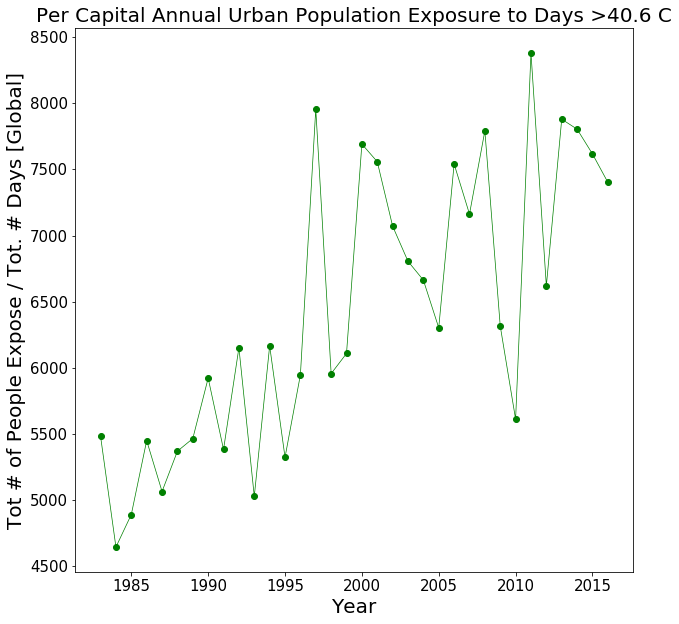

In [42]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

# Total Days
data = total_people / total_days
#sns.regplot(years, data, color = 'green', ax = ax1, label='_nolegend_')
ax1.plot(data, **kwargs, color = 'green')

# Title
ax1.set_title('Per Capital Annual Urban Population Exposure to Days >40.6 C', fontsize = 20)
ax1.set_ylabel('Tot # of People Expose / Tot. # Days [Global]', fontsize = 20)
ax1.set_xlabel('Year', fontsize = 20)
ax1.tick_params(labelsize = 15)

# legend
# leg_labels = ['People Days', 'People Days, 1983 population constant']
# plt.legend(leg_labels, fontsize = 15)

#plt.savefig(FIG_OUT+'AGU_Global_PersonDays.png')

In [45]:
(4*(400/(400+200)) + 6*(200/600)) + 7*

0.007777777777777777

In [46]:
400/(400+200)

0.6666666666666666

# What happens when we only look at people-events?

In [ ]:
data = df_stats

edays = pd.DataFrame()
edays['ID_HDC_G0'] = data['ID_HDC_G0']
edays['year'] = data['year']
edays['total_days'] = data['total_days']
edays['CTR_MN_NM'] = data['CTR_MN_NM']
edays['sub-region'] = data['sub-region']

In [ ]:
edays.groupby(['year','ID_HDC_G0'])['total_days'].count()